# Trp-cage

In [2]:
import pyemma
import numpy as np
import multiprocessing
import math

import matplotlib
import matplotlib.pyplot as plt

# NMM modules
import sys
sys.path.append('/Users/rafalpwiewiora/repos/NMpathAnalysis/nmpath')
from nmm import NonMarkovModel, MarkovPlusColorModel
from clustering import kinetic_clustering2_from_tmatrix, biggest_clusters_indexes
from mfpt import markov_commute_time

## Auxiliary functions

In [26]:
def calc_models(dtrajs, lag, stateA, stateB):
    
    msm = pyemma.msm.estimate_markov_model(dtrajs, lag)
    
    # haMSM estimation faster with lists -- pyemmma converts back to ndarrays
    dtrajs = [x.tolist() for x in dtrajs]

    nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=lag, clean_traj=True)
    nm_model_hist1  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=3*5, clean_traj=True)
    nm_model_hist2 = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=25*5, clean_traj=True)
    
    return [msm, nm_model, nm_model_hist1, nm_model_hist2]

## Read data

In [14]:
dtrajs = list(np.load('../../top_models/trpcage/trpcage_dtrajs.npy', allow_pickle=True))

## Find metastable states

### Intermediate size is 10% of all microstates

In [88]:
msm = pyemma.msm.estimate_markov_model(dtrajs, 100*5)
pcca = msm.pcca(2)

# unfolded - more states
stateA_index = np.argmax([len(x) for x in pcca.metastable_sets])
# folded - fewer states
stateB_index = np.argmin([len(x) for x in pcca.metastable_sets])

cutoff = 0.5
intermediate_len = 0
while intermediate_len < 0.1*msm.nstates:
           
    cutoff += 0.0001 # adjust to make possible to get desired intermediate

    stateA = np.concatenate(np.argwhere(pcca.memberships[:,stateA_index] > cutoff)).tolist()
    stateB = np.concatenate(np.argwhere(pcca.memberships[:,stateB_index] > cutoff)).tolist()

    intermediate_len = msm.nstates - len(stateA) - len(stateB)   

In [89]:
print('Intermediate size: {}, cutoff: {}'.format(intermediate_len, cutoff))
print('Unfolded size: {}, folded size: {}'.format(len(stateA), len(stateB)))

Intermediate size: 5, cutoff: 0.9285999999999528
Unfolded size: 43, folded size: 2


## Estimate MSMs and haMSMs

In [17]:
lags = [1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000]

In [27]:
pool = multiprocessing.Pool(8)

models = pool.starmap(calc_models, [(dtrajs, lag, stateA, stateB) for lag in lags])

pool.close()
pool.join()

## Calculate MFPTs

In [28]:
dt = 0.0002 # mfpts in microseconds

empirical_mfptsAB =[]
empirical_mfptsBA =[]
std_errAB = []
std_errBA = []

msm_mfptsAB = []
msm_mfptsBA = []

nm_mfptsAB = []
nm_mfptsBA = []

nm_hist1_mfptsAB = []
nm_hist1_mfptsBA = []

nm_hist2_mfptsAB = []
nm_hist2_mfptsBA = []
    
for models_ in models:
    
    msm_model = models_[0]
    nm_model = models_[1]
    nm_model_hist1 = models_[2]
    nm_model_hist2 = models_[3]
    
    msm_mfptsAB.append(msm_model.mfpt(stateA, stateB)*dt)
    msm_mfptsBA.append(msm_model.mfpt(stateB, stateA)*dt)
    
    e_kinetics = nm_model.empirical_mfpts()
    nm_kinetics = nm_model.mfpts()
    nm_model_hist1_kinetics = nm_model_hist1.mfpts()
    nm_model_hist2_kinetics = nm_model_hist2.mfpts()
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist1_mfptsAB.append(nm_model_hist1_kinetics['mfptAB']*dt)
    nm_hist1_mfptsBA.append(nm_model_hist1_kinetics['mfptBA']*dt)
    
    nm_hist2_mfptsAB.append(nm_model_hist2_kinetics['mfptAB']*dt)
    nm_hist2_mfptsBA.append(nm_model_hist2_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 37/37
Number of A->B/B->A  events: 20/20
Number of A->B/B->A  events: 18/18
Number of A->B/B->A  events: 15/15
Number of A->B/B->A  events: 14/14
Number of A->B/B->A  events: 11/11
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 9/9
Number of A->B/B->A  events: 5/6
Number of A->B/B->A  events: 3/4


## plot

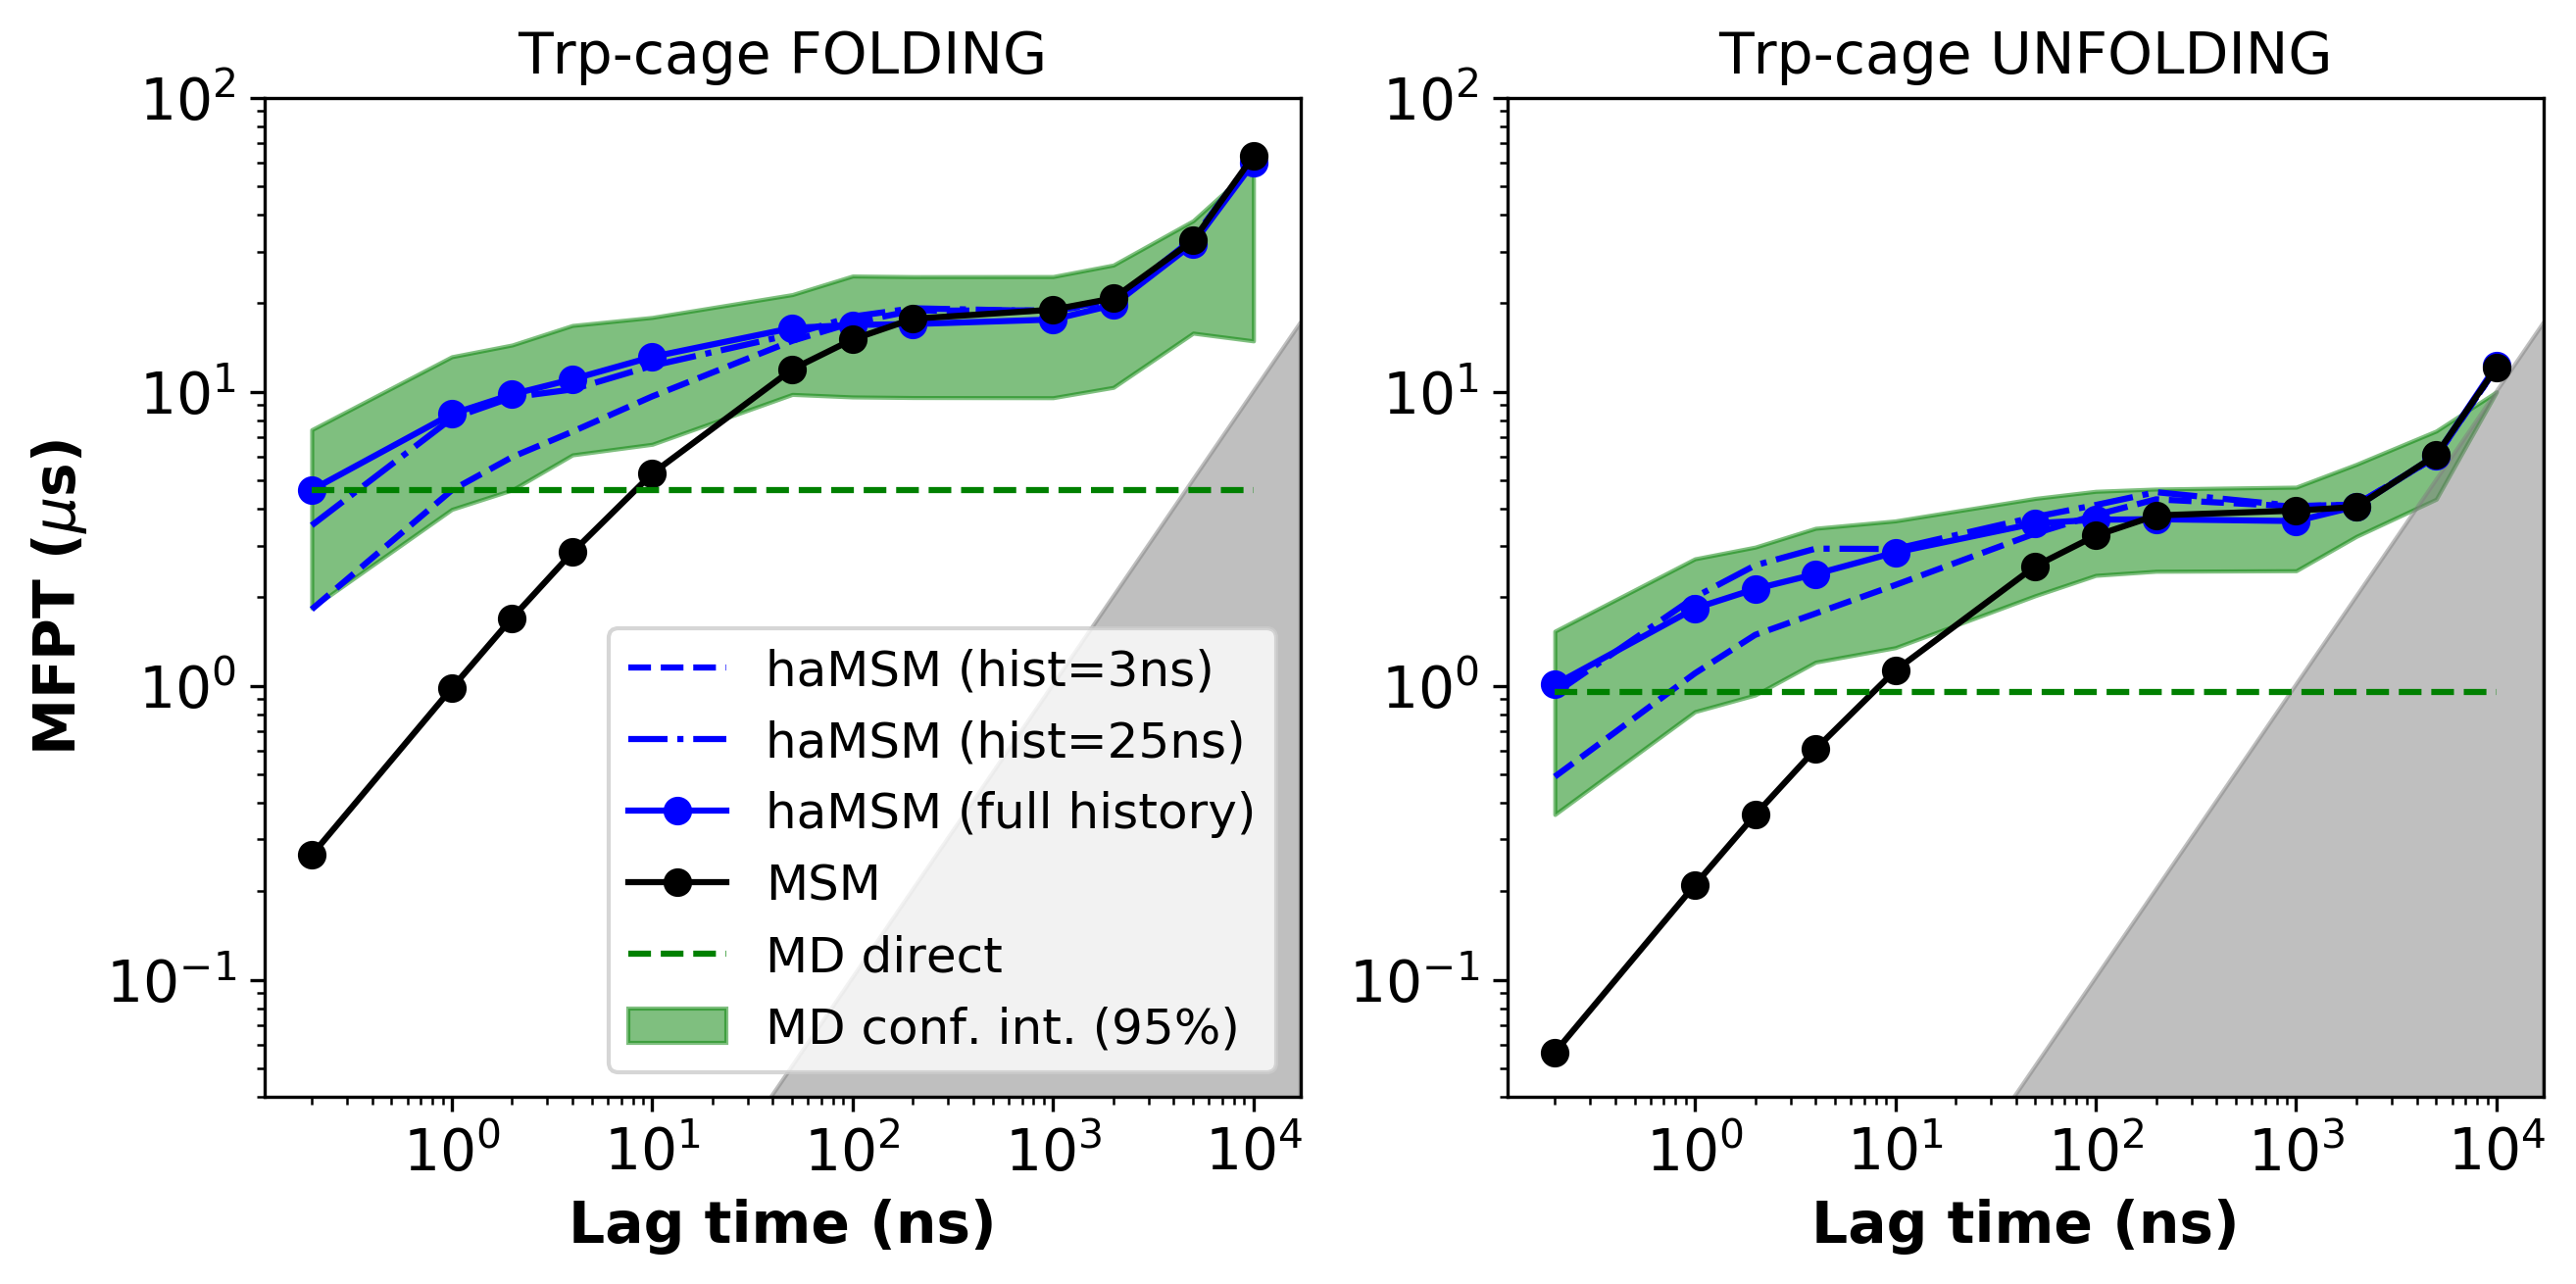

In [25]:
lags_ns = np.array(lags) * 0.2
lags_us = np.array(lags) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

fig = plt.figure(figsize = (10, 4.5), dpi=300)

ax1 = fig.add_subplot(121)

ax1.fill_between(lags_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="MD conf. int. (95%)")

ax1.plot(lags_ns, nm_hist1_mfptsAB, "--", label="haMSM (hist=3ns)", c='b')
ax1.plot(lags_ns, nm_hist2_mfptsAB, "-.", label="haMSM (hist=25ns)", c='b')
ax1.plot(lags_ns, nm_mfptsAB, "-o", label="haMSM (full history)", c='b')

ax1.plot(lags_ns, msm_mfptsAB, "-o", color='k', label="MSM")
ax1.plot(lags_ns, [empirical_mfptsAB[0] for i in lags_ns], "--", color='green', label='MD direct')

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Trp-cage FOLDING", fontsize=14)
ax1.set_xlabel("Lag time (ns)", weight='bold', fontsize=14)
ax1.set_ylabel("MFPT ($\mu$s)", weight='bold', fontsize=14)
ax1.tick_params(labelsize=14)
plt.legend(loc='lower right', fontsize=12)
ax1.set_ylim(4e-2, 1e2)
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)

ax2.fill_between(lags_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green")


ax2.plot(lags_ns, nm_hist1_mfptsBA, "--", c='b')
ax2.plot(lags_ns, nm_hist2_mfptsBA, "-.", c='b')
ax2.plot(lags_ns, nm_mfptsBA, "-o", c='b')

ax2.plot(lags_ns, msm_mfptsBA, "-o", color='k')
ax2.plot(lags_ns, [empirical_mfptsBA[0] for i in lags_ns], "--", color='green')

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Trp-cage UNFOLDING", fontsize=14)
ax2.set_xlabel("Lag time (ns)", weight='bold', fontsize=14)
ax2.tick_params(labelsize=14)
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)

plt.savefig('trpcage_mfpts.png', dpi=300)
plt.savefig('trpcage_mfpts.pdf')
plt.show()

## Sensitivity to the number of intermediate microstates

In [52]:
stateAs = []
stateBs = []
intermediate_lens = []

for i in np.arange(0.05, 0.75, 0.05):

    cutoff = 0.5
    intermediate_len = 0
    while intermediate_len < i*msm.nstates:
        
        cutoff += 0.0001 # adjust to make possible to get 10% intermediate

        stateA_ = np.concatenate(np.argwhere(pcca.memberships[:,stateA_index] > cutoff)).tolist()
        stateB_ = np.concatenate(np.argwhere(pcca.memberships[:,stateB_index] > cutoff)).tolist()

        intermediate_len = msm.nstates - len(stateA_) - len(stateB_) 
        
    stateAs.append(stateA_)
    stateBs.append(stateB_)
    intermediate_lens.append(intermediate_len)

intermediate_lens = np.array(intermediate_lens)

In [54]:
intermediate_lens

array([ 3,  5,  8, 10, 13, 15, 18, 20, 23, 25, 28, 31, 33, 35])

In [53]:
dt = 0.0002 # mfpts in microseconds

msm_mfptsAB_vsinterm = []
msm_mfptsBA_vsinterm = []

for i in range(len(intermediate_lens)):
    msm_mfptsAB_ = []
    msm_mfptsBA_ = []
    
    for models_ in models:
        msm_model = models_[0]
        msm_mfptsAB_.append(msm_model.mfpt(stateAs[i], stateBs[i])*dt)
        msm_mfptsBA_.append(msm_model.mfpt(stateBs[i], stateAs[i])*dt)
    
    msm_mfptsAB_vsinterm.append(msm_mfptsAB_)
    msm_mfptsBA_vsinterm.append(msm_mfptsBA_)

## plot

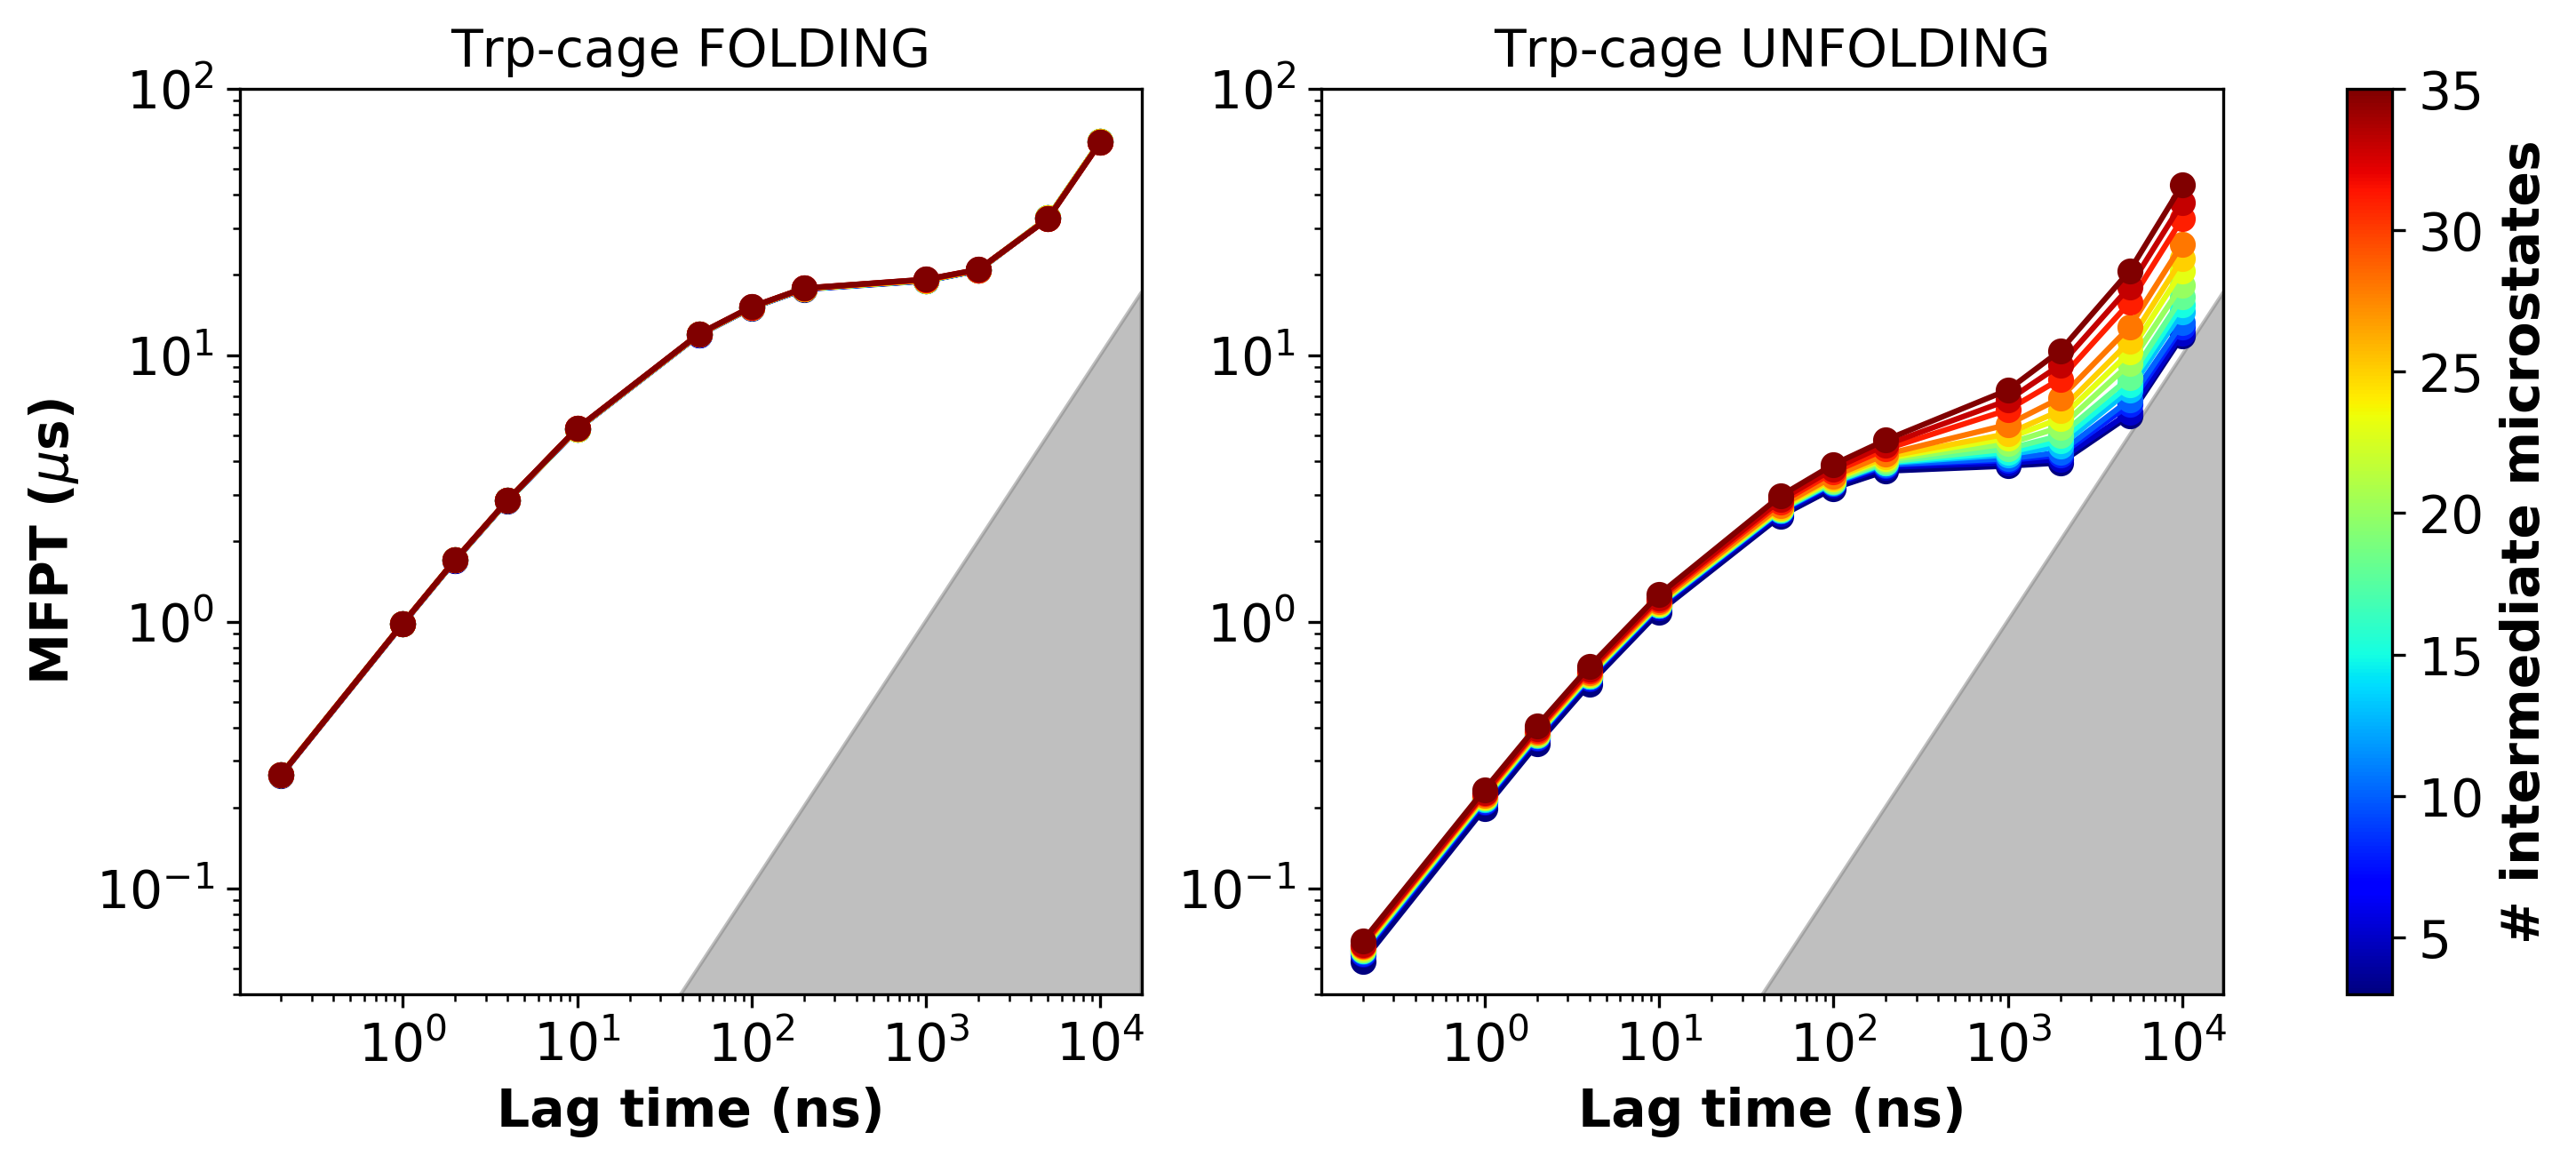

In [64]:
lags_ns = np.array(lags) * 0.2

fig=plt.figure(figsize = (12, 4.5), dpi=300)
ax1 = fig.add_subplot(121)

norm = matplotlib.colors.Normalize(vmin=intermediate_lens.min(), vmax=intermediate_lens.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

for i,msm_mfptAB in enumerate(msm_mfptsAB_vsinterm):
    ax1.plot(lags_ns, msm_mfptAB, "-o", color=cmap.to_rgba(intermediate_lens[i]))

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Trp-cage FOLDING", fontsize=14)
ax1.set_xlabel("Lag time (ns)", weight='bold', fontsize=14)
ax1.set_ylabel("MFPT ($\mu$s)", weight='bold', fontsize=14)
ax1.tick_params(labelsize=14)
ax1.set_ylim(4e-2, 1e2)
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)

for i,msm_mfptBA in enumerate(msm_mfptsBA_vsinterm):
    ax2.plot(lags_ns, msm_mfptBA, "-o", color=cmap.to_rgba(intermediate_lens[i]))

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Trp-cage UNFOLDING", fontsize=14)
ax2.set_xlabel("Lag time (ns)", weight='bold', fontsize=14)
ax2.tick_params(labelsize=14)
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)

cbar = fig.colorbar(cmap, ax=[ax1,ax2])
cbar.set_label('# intermediate microstates', weight='bold', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.savefig('trpcage_mfpts_msms_vsintermediate.png', dpi=300)
plt.savefig('trpcage_mfpts_msms_vsintermediate.pdf')
plt.show()

## Compare PCCA vs agglomerative clustering

In [65]:
K = models[0][0].P # lag 0.2 ns MSM
range_per_lag = [[200,3500]]

t_min_list=[]
t_max_list=[]
t_AB_list=[]

macrostates_list = []

# t_cut range
min_ = range_per_lag[0][0]
max_ = range_per_lag[0][1]
interval = (max_ - min_)//50
t_cut_values =  [min_+i for i in range(0,max_- min_,interval)]

for t_cut in t_cut_values:

    big_clusters=[]

    # clustering
    clusters, t_min, t_max = kinetic_clustering2_from_tmatrix(K, t_cut=t_cut)

    t_min_list.append(t_min)
    t_max_list.append(t_max)

    for i, cluster_i in enumerate(clusters):
        if len(cluster_i) > 1:
            big_clusters.append(cluster_i)

    n_big = len(big_clusters)

    macrostate_indexes = biggest_clusters_indexes(big_clusters, n_pick=2)

    if n_big > 1:
        #tAB = markov_commute_time(K,[big_clusters[macrostates[0]]], big_clusters[macrostates[1]])
        macrostateA = big_clusters[macrostate_indexes[0]]
        macrostateB = big_clusters[macrostate_indexes[1]]
        macrostates_list.append([macrostateA, macrostateB])
        tAB = models[0][0].mfpt(macrostateA, macrostateB) + models[0][0].mfpt(macrostateB, macrostateA)
    else:
        tAB = 0.0
    t_AB_list.append(tAB)

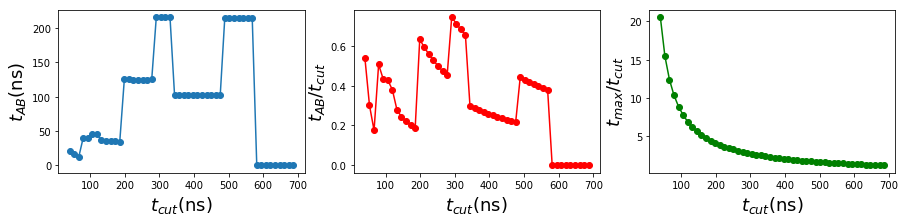

In [66]:
model = models[0][0]
dt = 0.2 # 0.2 ns lag MSM

t_cut_values_ns = np.array(t_cut_values)*dt
t_min_list_ns = np.array(t_min_list)*dt
t_max_list_ns = np.array(t_max_list)*dt
t_AB_list_ns = np.array(t_AB_list)*dt

fig = plt.figure(figsize=(15,3))

ax1 =  fig.add_subplot(131)
ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)

ax2 =  fig.add_subplot(132)
ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)

ax3 =  fig.add_subplot(133)
ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)

plt.show()

### PCCA tAB:

In [68]:
print('PCCA tAB: {} ns'.format((model.mfpt(stateA, stateB) + model.mfpt(stateB, stateA))*0.2))

PCCA tAB: 321.95260836845614 ns


In [137]:
# longest plateau at max value
t_AB_list_ns[34:41]

array([215.53007816, 215.53007816, 215.53007816, 215.53007816,
       215.53007816, 215.53007816, 215.53007816])

In [138]:
# longest plateau at max value
[(len(macrostates_list[index][0]), len(macrostates_list[index][1])) for index in range(len(macrostates_list))][34:41]

[(43, 4), (43, 4), (43, 4), (43, 4), (43, 4), (43, 4), (43, 4)]

In [150]:
stateA_agglom = macrostates_list[34][0]
stateB_agglom = macrostates_list[34][1]

intermediate_len_agglom = (msm.nstates - (len(stateA_agglom) + len(stateB_agglom)))

In [151]:
print('Agglomerative intermediate size: {}'.format(intermediate_len_agglom))

Agglomerative intermediate size: 3


## Estimate MSMs and haMSMs: agglomerative

In [154]:
pool = multiprocessing.Pool(8)

models_agglom = pool.starmap(calc_models, [(dtrajs, lag, stateA_agglom, stateB_agglom) for lag in lags])

pool.close()
pool.join()

## Calculate MFPTs: agglomerative

In [155]:
dt = 0.0002 # mfpts in microseconds

empirical_mfptsAB_agglom =[]
empirical_mfptsBA_agglom =[]
std_errAB_agglom = []
std_errBA_agglom = []

msm_mfptsAB_agglom = []
msm_mfptsBA_agglom = []

nm_mfptsAB_agglom = []
nm_mfptsBA_agglom = []

nm_hist1_mfptsAB_agglom = []
nm_hist1_mfptsBA_agglom = []

nm_hist2_mfptsAB_agglom = []
nm_hist2_mfptsBA_agglom = []
    
for models_ in models_agglom:
    
    msm_model = models_[0]
    nm_model = models_[1]
    nm_model_hist1 = models_[2]
    nm_model_hist2 = models_[3]
    
    msm_mfptsAB_agglom.append(msm_model.mfpt(stateA_agglom, stateB_agglom)*dt)
    msm_mfptsBA_agglom.append(msm_model.mfpt(stateB_agglom, stateA_agglom)*dt)
    
    e_kinetics = nm_model.empirical_mfpts()
    nm_kinetics = nm_model.mfpts()
    nm_model_hist1_kinetics = nm_model_hist1.mfpts()
    nm_model_hist2_kinetics = nm_model_hist2.mfpts()
    
    empirical_mfptsAB_agglom.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA_agglom.append(e_kinetics['mfptBA']*dt)
    std_errAB_agglom.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA_agglom.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB_agglom.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA_agglom.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist1_mfptsAB_agglom.append(nm_model_hist1_kinetics['mfptAB']*dt)
    nm_hist1_mfptsBA_agglom.append(nm_model_hist1_kinetics['mfptBA']*dt)
    
    nm_hist2_mfptsAB_agglom.append(nm_model_hist2_kinetics['mfptAB']*dt)
    nm_hist2_mfptsBA_agglom.append(nm_model_hist2_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 1117/1117
Number of A->B/B->A  events: 303/303
Number of A->B/B->A  events: 181/181
Number of A->B/B->A  events: 110/110
Number of A->B/B->A  events: 63/63
Number of A->B/B->A  events: 21/21
Number of A->B/B->A  events: 17/17
Number of A->B/B->A  events: 15/15
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 5/6
Number of A->B/B->A  events: 3/4


## Estimate MSMs and haMSMs: PCCA, same size of intermediate as agglom.

In [157]:
cutoff = 0.5
intermediate_len = 0
while intermediate_len < intermediate_len_agglom:
           
    cutoff += 0.0001 # adjust to make possible to get desired intermediate

    stateA = np.concatenate(np.argwhere(pcca.memberships[:,stateA_index] > cutoff)).tolist()
    stateB = np.concatenate(np.argwhere(pcca.memberships[:,stateB_index] > cutoff)).tolist()

    intermediate_len = msm.nstates - len(stateA) - len(stateB)   

In [158]:
print('Intermediate size: {}, cutoff: {}'.format(intermediate_len, cutoff))

Intermediate size: 3, cutoff: 0.8556999999999608


In [159]:
pool = multiprocessing.Pool(8)

models = pool.starmap(calc_models, [(dtrajs, lag, stateA, stateB) for lag in lags])

pool.close()
pool.join()

## Calculate MFPTs: PCCA, same size of intermediate as agglom.

In [160]:
dt = 0.0002 # mfpts in microseconds

empirical_mfptsAB =[]
empirical_mfptsBA =[]
std_errAB = []
std_errBA = []

msm_mfptsAB = []
msm_mfptsBA = []

nm_mfptsAB = []
nm_mfptsBA = []

nm_hist1_mfptsAB = []
nm_hist1_mfptsBA = []

nm_hist2_mfptsAB = []
nm_hist2_mfptsBA = []
    
for models_ in models:
    
    msm_model = models_[0]
    nm_model = models_[1]
    nm_model_hist1 = models_[2]
    nm_model_hist2 = models_[3]
    
    msm_mfptsAB.append(msm_model.mfpt(stateA, stateB)*dt)
    msm_mfptsBA.append(msm_model.mfpt(stateB, stateA)*dt)
    
    e_kinetics = nm_model.empirical_mfpts()
    nm_kinetics = nm_model.mfpts()
    nm_model_hist1_kinetics = nm_model_hist1.mfpts()
    nm_model_hist2_kinetics = nm_model_hist2.mfpts()
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist1_mfptsAB.append(nm_model_hist1_kinetics['mfptAB']*dt)
    nm_hist1_mfptsBA.append(nm_model_hist1_kinetics['mfptBA']*dt)
    
    nm_hist2_mfptsAB.append(nm_model_hist2_kinetics['mfptAB']*dt)
    nm_hist2_mfptsBA.append(nm_model_hist2_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 359/359
Number of A->B/B->A  events: 104/104
Number of A->B/B->A  events: 66/66
Number of A->B/B->A  events: 39/39
Number of A->B/B->A  events: 24/24
Number of A->B/B->A  events: 14/14
Number of A->B/B->A  events: 12/12
Number of A->B/B->A  events: 12/12
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 9/9
Number of A->B/B->A  events: 5/6
Number of A->B/B->A  events: 3/4


In [161]:
## plot

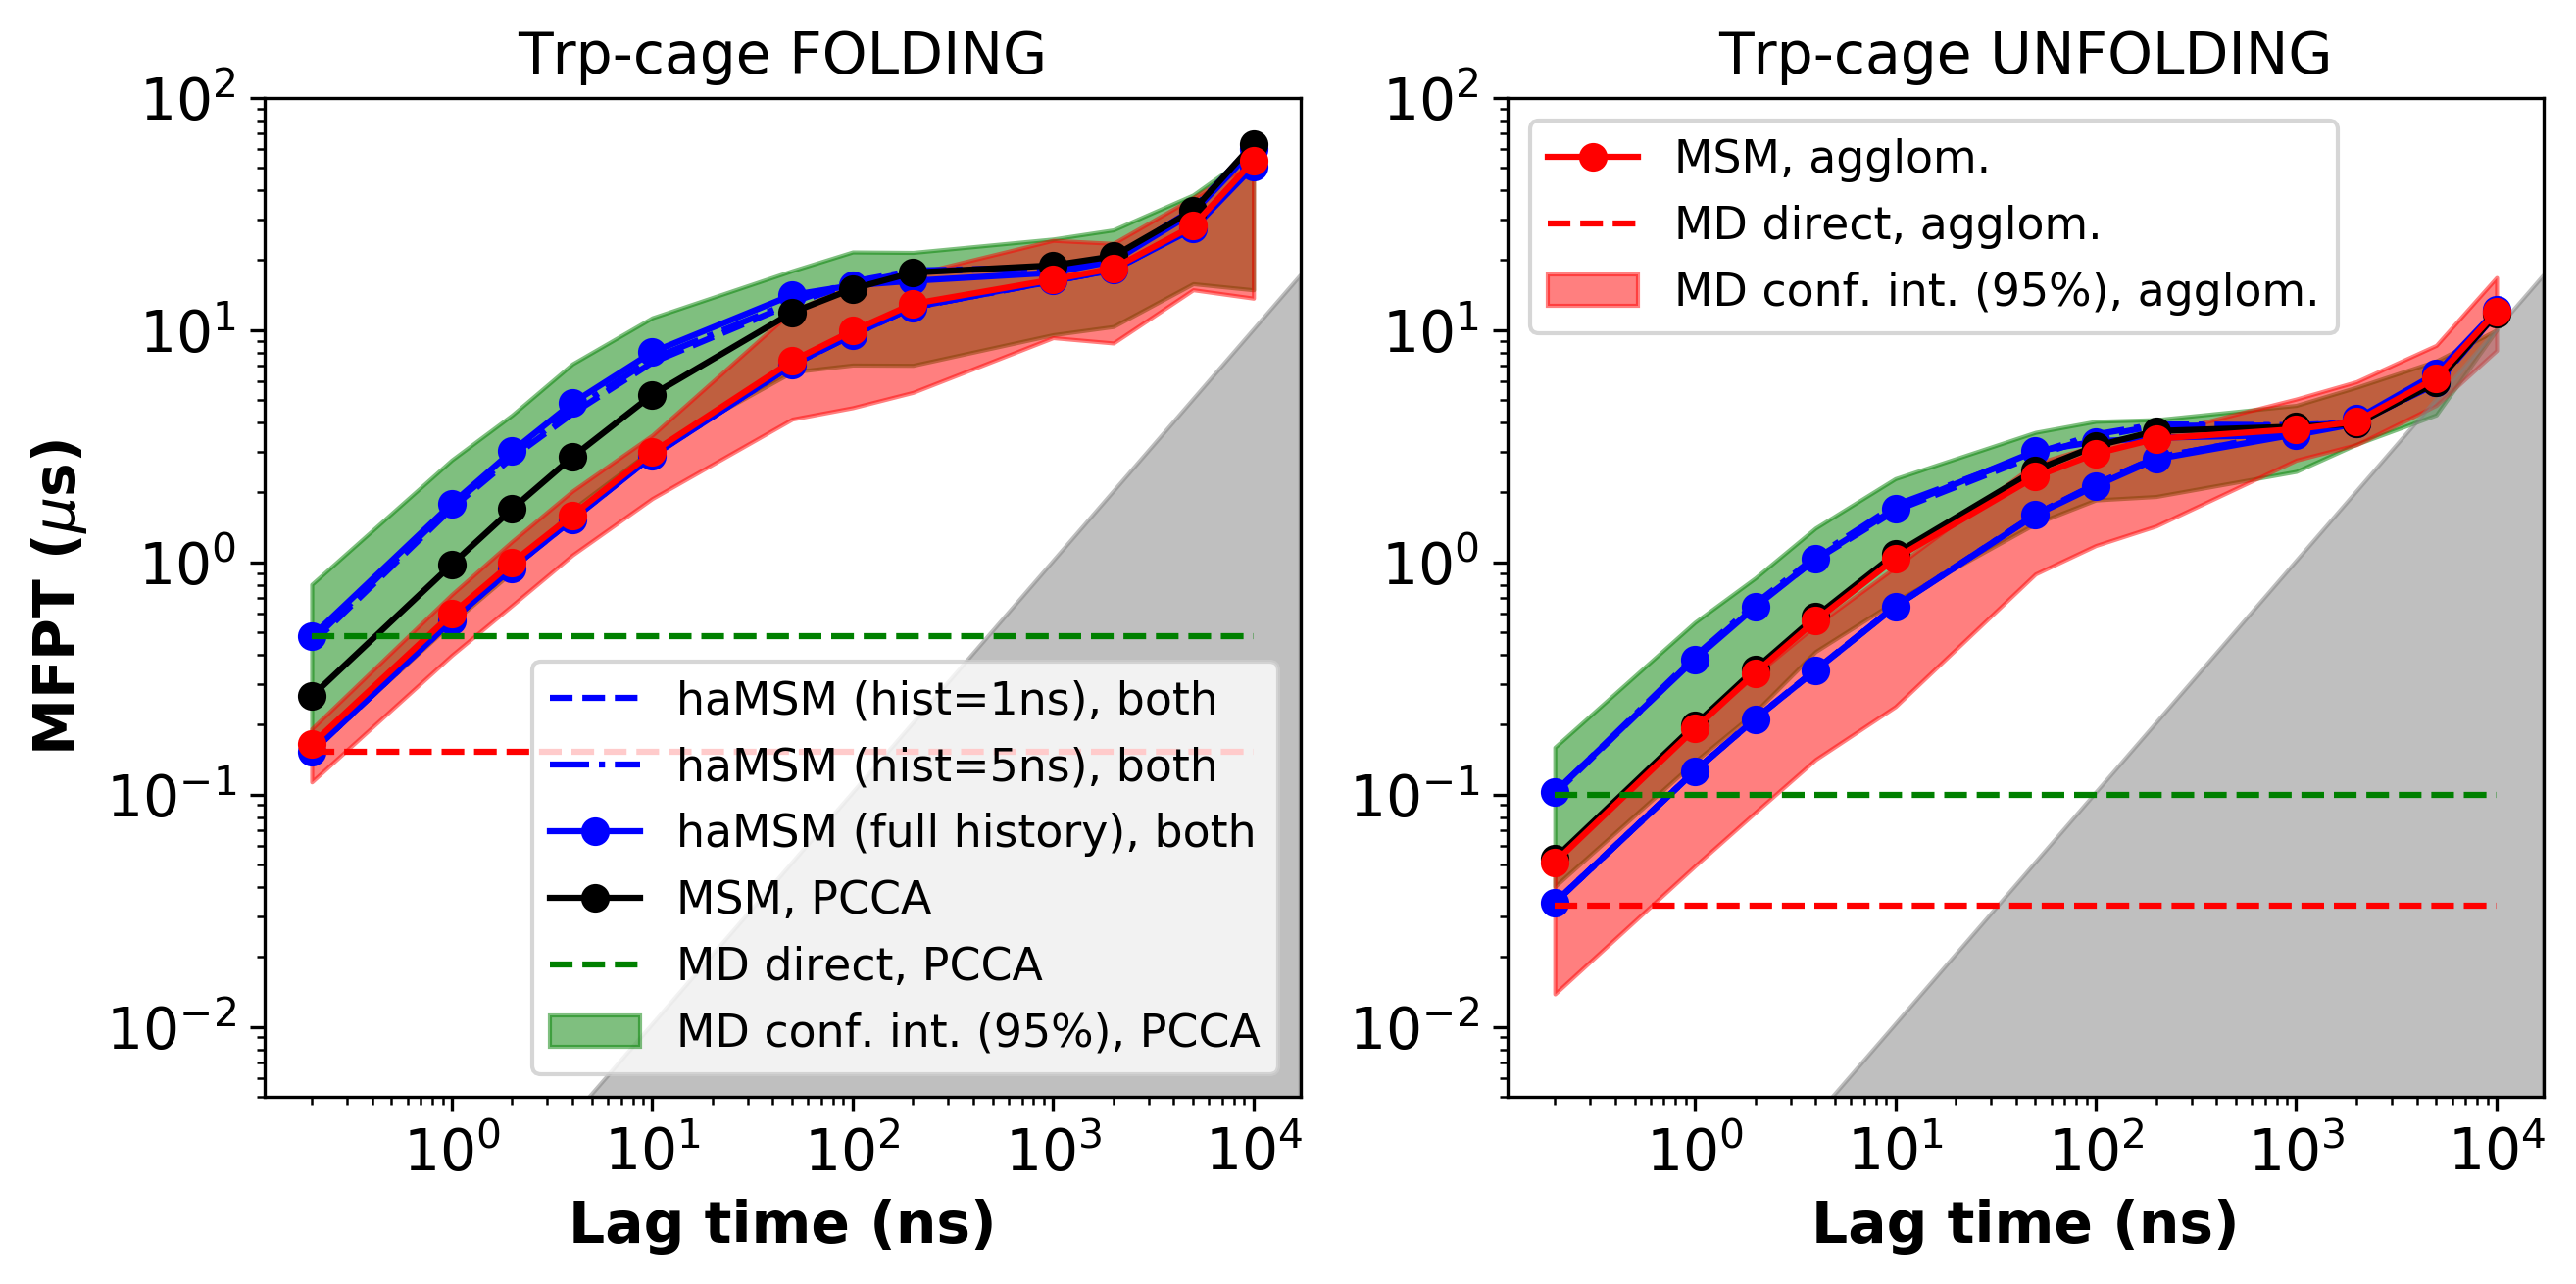

In [165]:
lags_ns = np.array(lags) * 0.2
lags_us = np.array(lags) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

empirical_mfptAB_max_agglom = np.array(empirical_mfptsAB_agglom) + 2*np.array(std_errAB_agglom)
empirical_mfptAB_min_agglom  = np.array(empirical_mfptsAB_agglom) - 2*np.array(std_errAB_agglom)

empirical_mfptBA_max_agglom = np.array(empirical_mfptsBA_agglom) + 2*np.array(std_errBA_agglom)
empirical_mfptBA_min_agglom = np.array(empirical_mfptsBA_agglom) - 2*np.array(std_errBA_agglom)

fig = plt.figure(figsize = (10, 4.5), dpi=300)

ax1 = fig.add_subplot(121)

ax1.fill_between(lags_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="MD conf. int. (95%), PCCA")

ax1.fill_between(lags_ns, empirical_mfptAB_min_agglom, empirical_mfptAB_max_agglom,
                 alpha=0.5, color="red")

ax1.plot(lags_ns, nm_hist1_mfptsAB, "--", label="haMSM (hist=1ns), both", c='b')
ax1.plot(lags_ns, nm_hist2_mfptsAB, "-.", label="haMSM (hist=5ns), both", c='b')
ax1.plot(lags_ns, nm_mfptsAB, "-o", label="haMSM (full history), both", c='b')

ax1.plot(lags_ns, nm_hist1_mfptsAB_agglom, "--", c='b')
ax1.plot(lags_ns, nm_hist2_mfptsAB_agglom, "-.", c='b')
ax1.plot(lags_ns, nm_mfptsAB_agglom, "-o", c='b')

ax1.plot(lags_ns, msm_mfptsAB, "-o", color='k', label="MSM, PCCA")
ax1.plot(lags_ns, msm_mfptsAB_agglom, "-o" ,color='r')

ax1.plot(lags_ns, [empirical_mfptsAB[0] for i in lags_ns], "--", color='green', label='MD direct, PCCA')
ax1.plot(lags_ns, [empirical_mfptsAB_agglom[0] for i in lags_ns], "--", color='red')

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Trp-cage FOLDING", fontsize=14)
ax1.set_xlabel("Lag time (ns)", weight='bold', fontsize=14)
ax1.set_ylabel("MFPT ($\mu$s)", weight='bold', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
ax1.tick_params(labelsize=14)
ax1.set_ylim(5e-3, 1e2)
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)

ax2.fill_between(lags_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green")

ax2.fill_between(lags_ns, empirical_mfptBA_min_agglom, empirical_mfptBA_max_agglom,
                 alpha=0.5, color="red", label="MD conf. int. (95%), agglom.")

ax2.plot(lags_ns, nm_hist1_mfptsBA, "--", c='b')
ax2.plot(lags_ns, nm_hist2_mfptsBA, "-.", c='b')
ax2.plot(lags_ns, nm_mfptsBA, "-o", c='b')

ax2.plot(lags_ns, nm_hist1_mfptsBA_agglom, "--", c='b')
ax2.plot(lags_ns, nm_hist2_mfptsBA_agglom, "-.", c='b')
ax2.plot(lags_ns, nm_mfptsBA_agglom, "-o", c='b')

ax2.plot(lags_ns, msm_mfptsBA, "-o", color='k')
ax2.plot(lags_ns, msm_mfptsBA_agglom, "-o" ,color='r', label='MSM, agglom.')

ax2.plot(lags_ns, [empirical_mfptsBA[0] for i in lags_ns], "--", color='green')
ax2.plot(lags_ns, [empirical_mfptsBA_agglom[0] for i in lags_ns], "--", color='red', label='MD direct, agglom.')

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Trp-cage UNFOLDING", fontsize=14)
ax2.set_xlabel("Lag time (ns)", weight='bold', fontsize=14)
plt.legend(loc='upper left', fontsize=11)
ax2.tick_params(labelsize=14)
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)

plt.savefig('trpcage_mfpts_pcca_vs_agglom.png', dpi=300)
plt.savefig('trpcage_mfpts_pcca_vs_agglom.pdf')
plt.show()